In [1]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install torchmetrics
!pip install torchinfo
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install matplotlib.pyplot
!pip install yfinance

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


Imports

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import torchvision
import torchvision.models as models
from torchvision import *
from torchvision import datasets
from torchvision.models.feature_extraction import create_feature_extractor

from torchmetrics import *

from torch.utils.data import *

import sklearn as sk
from sklearn import *
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

from itertools import compress


import matplotlib.pyplot as plt


import yfinance as yf


Data Processing

In [5]:
# time step to predict ahead, creates input sequences
# gonna have to figure out test
def create_lstm_data(data, time_step=1, future = 0,test_percent = .1):
    x_vec, y_vec = [], []
    # formats data so y = t and x = t-1, ... , t-time_steps
    for i in range(len(data) - time_step):
        split = i + time_step
        # checks if data is of same length for concatentation
        length = data[split : split + future, 0].shape[0]
        if(length == future):
            x_vec.append(data[i : split, 0].unsqueeze(0))
            y_vec.append(data[split : split + future, 0].unsqueeze(0))
    # calculate number of elements to allocate to test
    #dataset_length = len(x_vec)
    #num_of_train = dataset_length - (int)(test_percent * dataset_length)
    # concats x into matrix and y into vector, needs unsqueez to add single dimension for LSTM
    return torch.cat(x_vec,0).unsqueeze(-1), torch.cat(y_vec,0).unsqueeze(-1)#, torch.cat(x_vec[num_of_train:],0).unsqueeze(-1), torch.cat(y_vec[num_of_train:],0).unsqueeze(-1)

def create_train_and_test(data, time_step=1, future = 0,test_percent = .1):
    x_vec, y_vec = [], []
    # formats data so y = t and x = t-1, ... , t-time_steps
    for i in range(len(data) - time_step):
        split = i + time_step
        # checks if data is of same length for concatentation
        length = data[split : split + future, 0].shape[0]
        if(length == future):
            x_vec.append(data[i : split, 0].unsqueeze(0))
            y_vec.append(data[split : split + future, 0].unsqueeze(0))
    # calculate number of elements to allocate to test
    dataset_length = len(x_vec)
    num_of_train = dataset_length - (int)(test_percent * dataset_length)
    # concats x into matrix and y into vector, needs unsqueez to add single dimension for LSTM
    return torch.cat(x_vec[:num_of_train],0).unsqueeze(-1), torch.cat(y_vec[:num_of_train],0).unsqueeze(-1), torch.cat(x_vec[num_of_train:],0).unsqueeze(-1), torch.cat(y_vec[num_of_train:],0).unsqueeze(-1)

# create a dataset out of timeseries data, must be formatted first, tensor
# correct timeseries formatation
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]
    

Model Architecture

In [6]:
class PredictionLSTM(nn.Module):
    def __init__(self,input_len, hidden_size, num_layers, dropout = 0.5):
        super(PredictionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_len,hidden_size,num_layers,dropout=dropout,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hidden, cell):
        
        x = x.unsqueeze(1)
        #run data through LSTM
        out, (hidden, cell) = self.lstm(x.to(torch.float32),(hidden, cell))
        #get prediction from output of last timestep
        prediction  = self.fc(out[:,-1,:])
        #print(f'x shape {predc.shape}')
        return prediction, hidden, cell
    
class PairTradingLSTM(nn.Module):
    # initalize variables
    def __init__(self,input_len, hidden_size, num_layers, device, dropout = 0.5):
        super(PairTradingLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        
        # lstm model
        self.pred_lstm = PredictionLSTM(input_len,hidden_size,num_layers,dropout=dropout,)
        self.lstm = nn.LSTM(input_len,hidden_size,num_layers,dropout=dropout,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    # forward pass
    def forward(self, x, future = 0):
        #to store predicted outputs
        outputs = []
        
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype = torch.float32).to(self.device)
        cell_states = torch.zeros(self.num_layers, x.size(0),self.hidden_size, dtype = torch.float32).to(self.device)
        
        # output is hidden state of the last layer
        # out = [batch_size, 1, hidden_size]
        # hidden = (hidden_cell, cell_states) for all layers of LSTM
        
        out, (hidden, cell) = self.lstm(x.to(torch.float32), (hidden_states, cell_states))
        # extracting the hidden states the last timestep
        out = self.fc(out[:,-1,:])
        outputs.append(out)
        
        #predicts, n-1 = future, n-1 time step ahead since already predicted one above
        for i in range(future-1):
            
            out, hidden, cell = self.pred_lstm(out, hidden, cell)
            outputs.append(out)
            
        outputs = torch.cat(outputs, dim = 1) 
        
        return outputs
        
        

Training Loop

In [7]:
def train_epoch(model,dataloader, future, loss_fn,optimizer):
    
    model.train()
    running_loss = 0.0

    for X, y in dataloader:
        X_train, y_train = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        output = model(X_train, future)
        loss = loss_fn(output, y_train.squeeze(2))
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss = running_loss / len(train_dataloader)
    print(f'Train Average Loss: {avg_loss}')

Formatting Data

In [8]:
# Download stock data from Yahoo Finance
hmc_data = yf.download('HMC', period='10y')['Close']
hymtf_data = yf.download('HYMTF', period='10y')['Close']
# get spread
spread = hmc_data - hymtf_data
spread = spread.values.reshape(-1,1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
#parameters for data
BATCH_SIZE = 64
time_step = 30
future = 60

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
#transforms/normalizes data and converts it to a tensor
normalized_data = torch.tensor(scaler.fit_transform(spread))
X_train, y_train = create_lstm_data(normalized_data, time_step, future)
#creates dataset
train_dataset = TimeSeriesDataset(X_train,y_train)
#test_dataset = TimeSeriesDataset(X_test,y_test)
#puts dataset into dataloader
train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE)
#test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE)

In [12]:
train_dataset.

2518

Training

In [11]:
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'
#hyperparameters
hidden_size = 30
num_layers = 6
dropout = 0.5
model = PairTradingLSTM(1,hidden_size,num_layers,device, dropout).to(device)

In [12]:
lr = 0.001
num_epochs = 100
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [13]:
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    train_epoch(model, train_dataloader, future, loss, optimizer)

Epoch: 0
Train Average Loss: 0.10709667205810547
Epoch: 1
Train Average Loss: 0.03144296631217003
Epoch: 2
Train Average Loss: 0.03438038006424904
Epoch: 3
Train Average Loss: 0.033479634672403336
Epoch: 4
Train Average Loss: 0.032393407076597214
Epoch: 5
Train Average Loss: 0.03139704838395119
Epoch: 6
Train Average Loss: 0.03051186166703701
Epoch: 7
Train Average Loss: 0.029962630942463875
Epoch: 8
Train Average Loss: 0.02945229969918728
Epoch: 9
Train Average Loss: 0.028870215639472008
Epoch: 10
Train Average Loss: 0.028437793254852295
Epoch: 11
Train Average Loss: 0.02810657024383545
Epoch: 12
Train Average Loss: 0.027751417830586433
Epoch: 13
Train Average Loss: 0.027437960729002953
Epoch: 14
Train Average Loss: 0.027223743498325348
Epoch: 15
Train Average Loss: 0.027005154639482498
Epoch: 16
Train Average Loss: 0.026802966371178627
Epoch: 17
Train Average Loss: 0.026575880125164986
Epoch: 18
Train Average Loss: 0.026137491688132286
Epoch: 19
Train Average Loss: 0.0260296892374753

Testing

torch.Size([2427, 60]) | torch.Size([2427, 30, 1]) | torch.Size([2427, 60, 1])


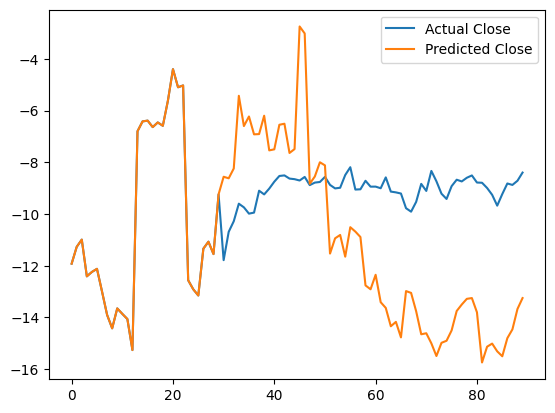

In [20]:
with torch.inference_mode():
    predicted = model(X_train.to(device).to(torch.float32),future).to(device)

#y_train = format_back(y_train, 7)
#y_pred = format_back(predicted, 7)

print(f'{predicted.shape} | {X_train.shape} | {y_train.shape}')

i = 300

pred_with_x = torch.concat([X_train.squeeze(2).cpu(),predicted.cpu()],1)
y_with_x = torch.concat([X_train.squeeze(2).cpu(),y_train.squeeze(2).cpu()],1)

true_y_train = scaler.inverse_transform(pred_with_x)
true_y_pred = scaler.inverse_transform(y_with_x)

plt.plot(true_y_train[i], label = 'Actual Close')
plt.plot(true_y_pred[i], label = 'Predicted Close')
plt.legend()

#true_y_pred[1], true_y_train[1]